In [38]:
import pandas as pd
from db import Database
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
import matplotlib.colors as mpcolors

db = Database()

In [214]:

def get_df(db: Database, mwname, pcap_id, g: bool, pt: str, slot_h=1.0, nn=1, max_slots_h=0):

    if g:
        if pt == 'q':
            where = 'rn_qr=1 and is_r is false'
        elif pt == 'r':
            where = 'rn_qr=1 and is_r is true'
        elif pt == 'ok':
            where = 'rn_qr_rcode=1 and rcode = 0'
        elif pt == 'nx':
            where = 'rn_qr_rcode=1 and rcode = 3'
    else:
        if pt == 'q':
            where = 'is_r is false'
        elif pt == 'r':
            where = 'is_r is true'
        elif pt == 'ok':
            where = 'rcode = 0'
        elif pt == 'nx':
            where = 'rcode = 3'


    slot_seconds = 3600 * slot_h
    upper_where = ''
    if max_slots_h > 0:
        max_slots_time = max_slots_h/slot_h
        upper_where = f' and FLOOR(time_s_translated / {slot_seconds}) < {max_slots_time}'
        pass

    if pcap_id:
        df = pd.read_sql(f"""
        SELECT EPS{nn} < 0.5 AS pn, EPS{nn} >= 0.5 AS pp, time_s_translated, FLOOR(time_s_translated / {slot_seconds}) as "hour" from public.get_message_pcap_all3({pcap_id},0)
        where {where} {upper_where}
        """, db.engine)
    else:
        df = pd.read_sql(f"""
        SELECT EPS{nn} < 0.5 AS pn, EPS{nn} >= 0.5 AS pp, time_s_translated, FLOOR(time_s_translated / {slot_seconds}) as "hour" from public.get_message_healthy_all2()
        where {where} {upper_where}
        """, db.engine)

    df = df.groupby("hour").aggregate({"pn": "sum", "pp": 'sum'})

    df.index.name = 'slot'
    df = df.reset_index()
    slots  = df.index.to_numpy().astype(int)
    slots = slots - slots.min()

    index2 = []
    missing = []
    for i in range(slots.max()):
        if i not in slots:
            index2.append(i)
            missing.append(0)
            pass

    print(df.index.min(), df.index.max(), len(missing))

    df_missing = pd.concat([pd.Series(index2, name='slot'), pd.Series(missing, name='pn'), pd.Series(missing, name='pp')], axis=1)

    if len(missing) > 0:
        df = pd.concat([df, df_missing], axis=0).sort_values(by='slot')
        pass

    display(df.value_counts())

    print(df.index.min(), df.index.max(), df.shape[0])

    return df.reset_index()

get_df(db, 'caphaw', 54, True, 'nx', slot_h=1)

0 777 227


slot    pn  pp
211.0   1   2     1
837.0   0   0     1
830.0   4   4     1
831.0   0   0     1
        6   8     1
                 ..
560.0   2   7     1
561.0   3   6     1
562.0   2   4     1
563.0   2   4     1
1005.0  1   2     1
Name: count, Length: 1005, dtype: int64

0 777 1005


,index,slot,pn,pp
0,0,211.0,1,2
1,1,212.0,0,2
2,2,213.0,1,3
3,3,214.0,0,2
4,4,215.0,0,3
...,...,...,...,...
1000,775,1003.0,4,5
1001,225,1003.0,0,0
1002,776,1004.0,2,9
1003,226,1004.0,0,0


In [208]:

dfs = {
    'healthy': get_df(db, 'healthy', None, True, 'nx', slot_h=1),
    'caphaw': get_df(db, 'caphaw', 54, True, 'nx', slot_h=1),
    'zbot': get_df(db, 'zbot', 46, True, 'nx', slot_h=1),
    'simda': get_df(db, 'simda', 58, True, 'nx', slot_h=1),
    'unknown': get_df(db, 'unknown', 57, True, 'nx', slot_h=1)
}


0.0 67.0 42
0.0 67.0 68
0.0 794.0 221
0.0 794.0 999
0.0 1005.0 524
0.0 1005.0 1006
0.0 219.0 219
0.0 219.0 267
0.0 122.0 122
0.0 122.0 130


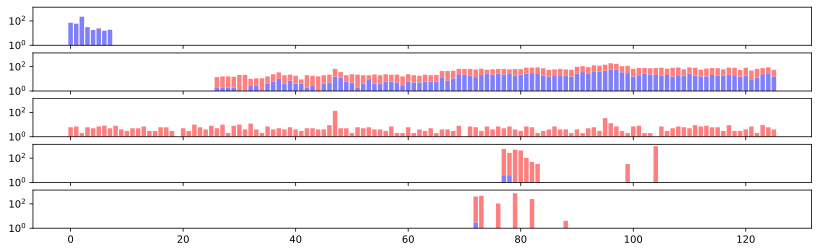

In [114]:

fig, axs = plt.subplots(5, 1, figsize=(14,4), sharey=True, sharex=True)

dfh = dfs['healthy']

dfh.loc[9:, 'pp'] = 0
dfh.loc[9:, 'pn'] = 0

i = 0
for mw in dfs:
    df = dfs[mw]


    negcolor = (127/255, 127/255, 255/255, 1)
    poscolor = (255/255, 127/255, 127/255, 1)

    axs[i].bar(df.index, df['pn'], color=mpcolors.to_rgba(negcolor))
    axs[i].bar(df.index, df['pp'], bottom=df['pn'], color=mpcolors.to_rgba(poscolor))

    axs[i].set_yscale('log')

    i += 1

    pass


slot
0.0    1
1.0    1
2.0    1
3.0    1
4.0    1
5.0    1
6.0    1
7.0    1
Name: count, dtype: int64

slot
0.0     2
1.0     2
58.0    2
57.0    2
56.0    2
       ..
25.0    2
24.0    2
23.0    2
22.0    2
79.0    2
Name: count, Length: 80, dtype: int64

slot
0.0     2
23.0    2
74.0    2
68.0    2
65.0    2
62.0    2
59.0    2
50.0    2
47.0    2
43.0    2
40.0    2
37.0    2
33.0    2
30.0    2
28.0    2
25.0    2
78.0    2
20.0    2
8.0     2
3.0     2
16.0    2
11.0    2
13.0    2
22.0    1
66.0    1
57.0    1
61.0    1
7.0     1
63.0    1
6.0     1
4.0     1
55.0    1
69.0    1
70.0    1
72.0    1
73.0    1
75.0    1
77.0    1
56.0    1
53.0    1
54.0    1
14.0    1
19.0    1
31.0    1
18.0    1
35.0    1
36.0    1
38.0    1
1.0     1
27.0    1
44.0    1
45.0    1
49.0    1
10.0    1
51.0    1
52.0    1
41.0    1
Name: count, dtype: int64

slot
0.0     2
23.0    2
25.0    2
26.0    2
27.0    2
       ..
56.0    1
57.0    1
58.0    1
59.0    1
79.0    1
Name: count, Length: 80, dtype: int64

slot
0.0     2
73.0    2
49.0    2
26.0    2
25.0    2
       ..
27.0    1
24.0    1
23.0    1
22.0    1
79.0    1
Name: count, Length: 80, dtype: int64

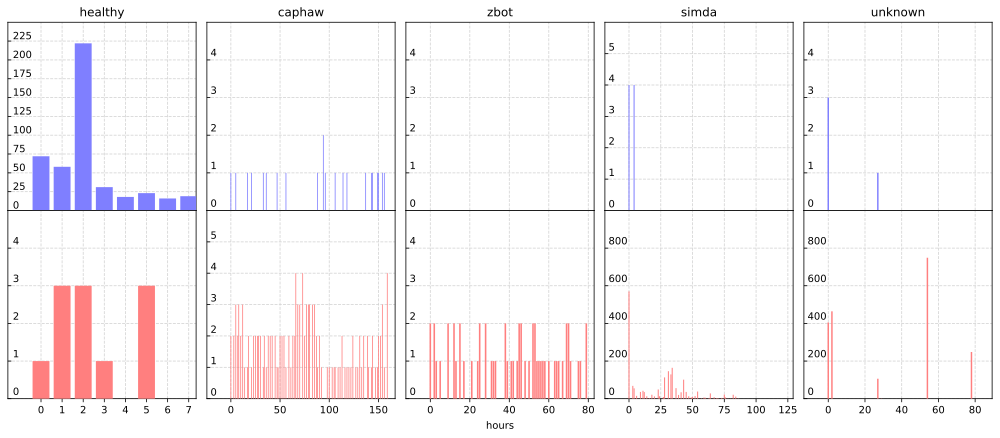

In [210]:

fig, axs = plt.subplots(2, 5, figsize=(14,6), sharey=False, sharex='col')

dfh = dfs['healthy']

dfh.loc[9:, 'pp'] = 0
dfh.loc[9:, 'pn'] = 0


i = 0
for mw in dfs:
    df = dfs[mw]
    if mw == 'healthy':
        df = df[df.slot < 8]
        axs[0,i].set_xticks(list(range(8)))
        axs[1,i].set_xticks(list(range(8)))
    else:
        df = df[df.slot < 80]

    display(df.slot.value_counts())

    negcolor = (127/255, 127/255, 255/255, 1)
    poscolor = (255/255, 127/255, 127/255, 1)

    # axs[i].set_yscale('log')

    axs[0,i].bar(df.index, df['pn'], color=mpcolors.to_rgba(negcolor), zorder=20)
    axs[1,i].bar(df.index, df['pp'], color=mpcolors.to_rgba(poscolor), zorder=20)

    for k, col in [(0, 'pn'), (1, 'pp')]:
        p = -20
        if df[col].max() < 5:
            s = 1
            m = 6
            p = -10
        elif df[col].max() < 100:
            s = 20
            m = 5
            p = -15
        elif df[col].max() < 500:
            s = 25
            m = 8
        elif df[col].max() < 1000:
            s = 200
            m = 5
        else:
            s = 25
            pass
        m = int(df[col].max() / s) + 2
        if m < 5:
            m = 5

        axs[k, i].grid(True, axis='both', linestyle='--', color='lightgray', zorder=-20)
        axs[k, i].set_yticks(list(map(lambda x: int(s * x), range(m))), [])

        axs[k, i].tick_params(axis="y", direction="in", labelleft=True, pad=500, labelsize='small', labelcolor='white')
        axs[k, i].set_ylim(0, m*s)

        
        axs[k,i].margins(0.15, s) # 5% padding in all directions

        xlim = axs[k,i].get_xlim()

        for l in range(m):
            axs[k,i].text(xlim[0] + abs(xlim[0]*0.15), l*s + s/10, l*s, horizontalalignment='left')
            pass

        axs[k,i].set_xlim(xlim[0], df.index.max()*1.05)
        pass

    axs[0,i].set_title(mw)
    i += 1
    pass

fig.tight_layout()
fig.text(0.5, -0.01, "hours", ha='center', va='bottom')
fig.subplots_adjust(hspace=0)